<h1>Identifying Win or Loss of League of Legends Games at the 10 Minute Marker</h1>

<h5>Dylan Wadsworth</h5>

League of Legends is an extremely competitive game and currently dominates the esports scene. It brings in 1.2 million peak viewers, which is more than double that of esports' second most viewed game Minecraft, with 516 thousand peak viewers. "High-elo" games are those in which the best players compete to further increase their rank. As the competition increases towards the top of the rank scoreboard, these games are won or loss at a much faster pace, with the highest rank, Challenger, averaging a duration of 4 minutes less than the lowest rank. Therefore, one could posit that the initial moves of higher ranked elo games are characteristically more important to the win or loss of the game. This analysis serves to build a model that can classify the win or loss of a game by the game stats at the 10 minute mark. This is 19 minutes before the average end of game time at the highest elo. The overall reasoning behind making these predictions is that they could be employed in a web app that provides this information to players. Later on, using the API created by Riot Games (the developer of League of Legends), data could be extracted regularly; therefore, when building the model, the goal should be to only push for more prediction power if there isn't a cost to interpretability. This would reveal what players need to fix to increase their win/loss ratio, and provide them with insights that could be drawn momentarily, perhaps even while the game is still being played.

<h3>Data Preprocessing</h3>

<h4>Imports</h4>

In [1]:
# Imports
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

<h4>Functions</h4>

In [2]:
def get_metrics(y_true, yhat):
    return {"F1_Score": metrics.f1_score(y_true=y_true, y_pred=yhat), "Accuracy_Score": metrics.accuracy_score(y_true=y_true, y_pred=yhat)}

<h4>Dataset</h4>

This is the <a href=https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min>dataset</a> I'll be working with. It has 38 feature columns comprised of blue and red team stats at the 10 minute mark. Each entry should be a unique game.

In [3]:
# Download dataset
# od.download("https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min")

In [4]:
# Read csv file into pandas dataframe
data = pd.read_csv('league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv')

In [5]:
# Examining head of data file
data.head(10)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
5,4475365709,1,18,0,0,5,3,6,1,1,...,0,15201,7.0,18060,221,59,-698,-101,22.1,1520.1
6,4493010632,1,18,3,1,7,6,7,1,1,...,0,14463,6.4,15404,164,35,-2411,-1563,16.4,1446.3
7,4496759358,0,16,2,0,5,13,3,0,0,...,0,17920,6.6,16938,157,54,2615,800,15.7,1792.0
8,4443048030,0,16,3,0,7,7,8,0,0,...,0,18380,7.2,19298,240,53,1979,771,24.0,1838.0
9,4509433346,1,13,1,1,4,5,5,1,1,...,0,16605,6.8,18379,247,43,1548,1574,24.7,1660.5


All entries are unique games, by their gameId

In [6]:
# Make sure all rows are unique games by their id
data.loc[:,'gameId'].unique().size == data.shape[0]

True

In [7]:
print(f"There are {data.shape[0]} entries and {data.shape[1]-1} features")

There are 9879 entries and 39 features


Viewing the columns shows that there are some redundant features due to the nature of League of Legends and how the game goes. I explain their redundancy next as I remove them.

In [8]:
# View all columns
print(data.columns.to_list())

['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters', 'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff', 'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed', 'redFirstBlood', 'redKills', 'redDeaths', 'redAssists', 'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed', 'redTotalGold', 'redAvgLevel', 'redTotalExperience', 'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff', 'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin']


<h4>Cleaning</h4>

There are no missing values.

In [9]:
# Check for missing values
null_values = data.isnull().sum()
for column in null_values.index:
    if null_values[column] != 0:
        print(f"Null values in {column}")

Here I remove some columns when splitting into features and target
<ol>
    <li><b>redGoldDiff</b> because it is -1 * 'blueGoldDiff'</li>
    <li><b>redGoldPerMin</b> because it is 'redTotalGold' / 10</li>
    <li><b>blueGoldPerMin</b> because it is 'blueTotalGold' / 10</li>
    <li><b>blueAvgLevel</b> because it is a division of 'blueTotalExperience'</li>
    <li><b>redAvgLevel</b> because it is a division of 'redTotalExperience'</li>
    <li><b>gameId</b> because every gameId is unique</li>
</ol>

In [10]:
# Split data into features and target
feature_cols = [x for x in data.columns if x != 'redGoldDiff' and x != 'redGoldPerMin' and x != 'blueGoldPerMin' and
               x != 'blueAvgLevel' and x != 'redAvgLevel' and x != 'gameId' and x != 'blueWins']
X = data.loc[:, feature_cols]
y = data.loc[:, 'blueWins']

Examining the data types shows me that its all numerical data so no feature encoding is necessary

In [11]:
# Check that all data types are numerical
obj_cols = [x for x in X.dtypes if x == object]
print(f"Amount of object columns: {len(obj_cols)}")
print(f"Is the target variable an object type? {y.dtypes == object}")
print(f"\nFeature data types\n------\n{X.dtypes}")
print(f"\nTarget data type\n------\n{y.dtypes}")

Amount of object columns: 0
Is the target variable an object type? False

Feature data types
------
blueWardsPlaced                   int64
blueWardsDestroyed                int64
blueFirstBlood                    int64
blueKills                         int64
blueDeaths                        int64
blueAssists                       int64
blueEliteMonsters                 int64
blueDragons                       int64
blueHeralds                       int64
blueTowersDestroyed               int64
blueTotalGold                     int64
blueTotalExperience               int64
blueTotalMinionsKilled            int64
blueTotalJungleMinionsKilled      int64
blueGoldDiff                      int64
blueExperienceDiff                int64
blueCSPerMin                    float64
redWardsPlaced                    int64
redWardsDestroyed                 int64
redFirstBlood                     int64
redKills                          int64
redDeaths                         int64
redAssists          

<h4>Preprocessing Summary</h4>

The dataset consists of 9879 entries with 39 features and 1 target variable. I removed 6 features, so 33 are left. There were no missing values, and all data types are numeric so no feature encoding was needed. The target variable has two classes: 0 and 1. Every entry has a unique gameId which ensures that they're all unique games with completely different stats, and increases the legitimacy of the model.

<h3>Exploratory Data Analysis</h3>

<h4>Univariate Analysis</h4>

Looking at the target variable, there are two classes so this is a binary classification problem and it appears to be quite balanced.

In [12]:
# Check for how many target classes there are (should be just two, 1 for blue wins, 0 for red wins)
y.nunique()

2

In [13]:
# Check for balance of the classes
y.value_counts()

blueWins
0    4949
1    4930
Name: count, dtype: int64

blueWins
0    4949
1    4930
Name: count, dtype: int64

Percentage of entries where blueWins is true (== 1): 49.90%




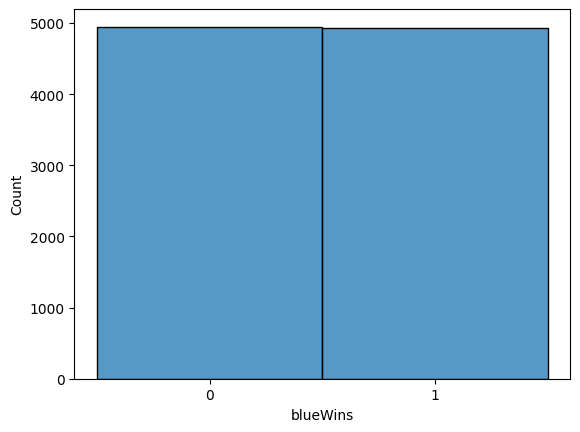

In [14]:
# Plot the balance of classes
plot = sns.histplot(y, discrete=True)
plot.set_xticks(range(0, 2))

print(y.value_counts())
print(f"\nPercentage of entries where blueWins is true (== 1): {(y.value_counts()[1] / y.shape[0]) * 100:.2f}%\n\n")

Now looking at the balance of total gold of red and blue teams, the values seem pretty straightforward. Lower gold values are easier to obtain, therefore there are more of them. They seem to fairly balanced between each other as well.

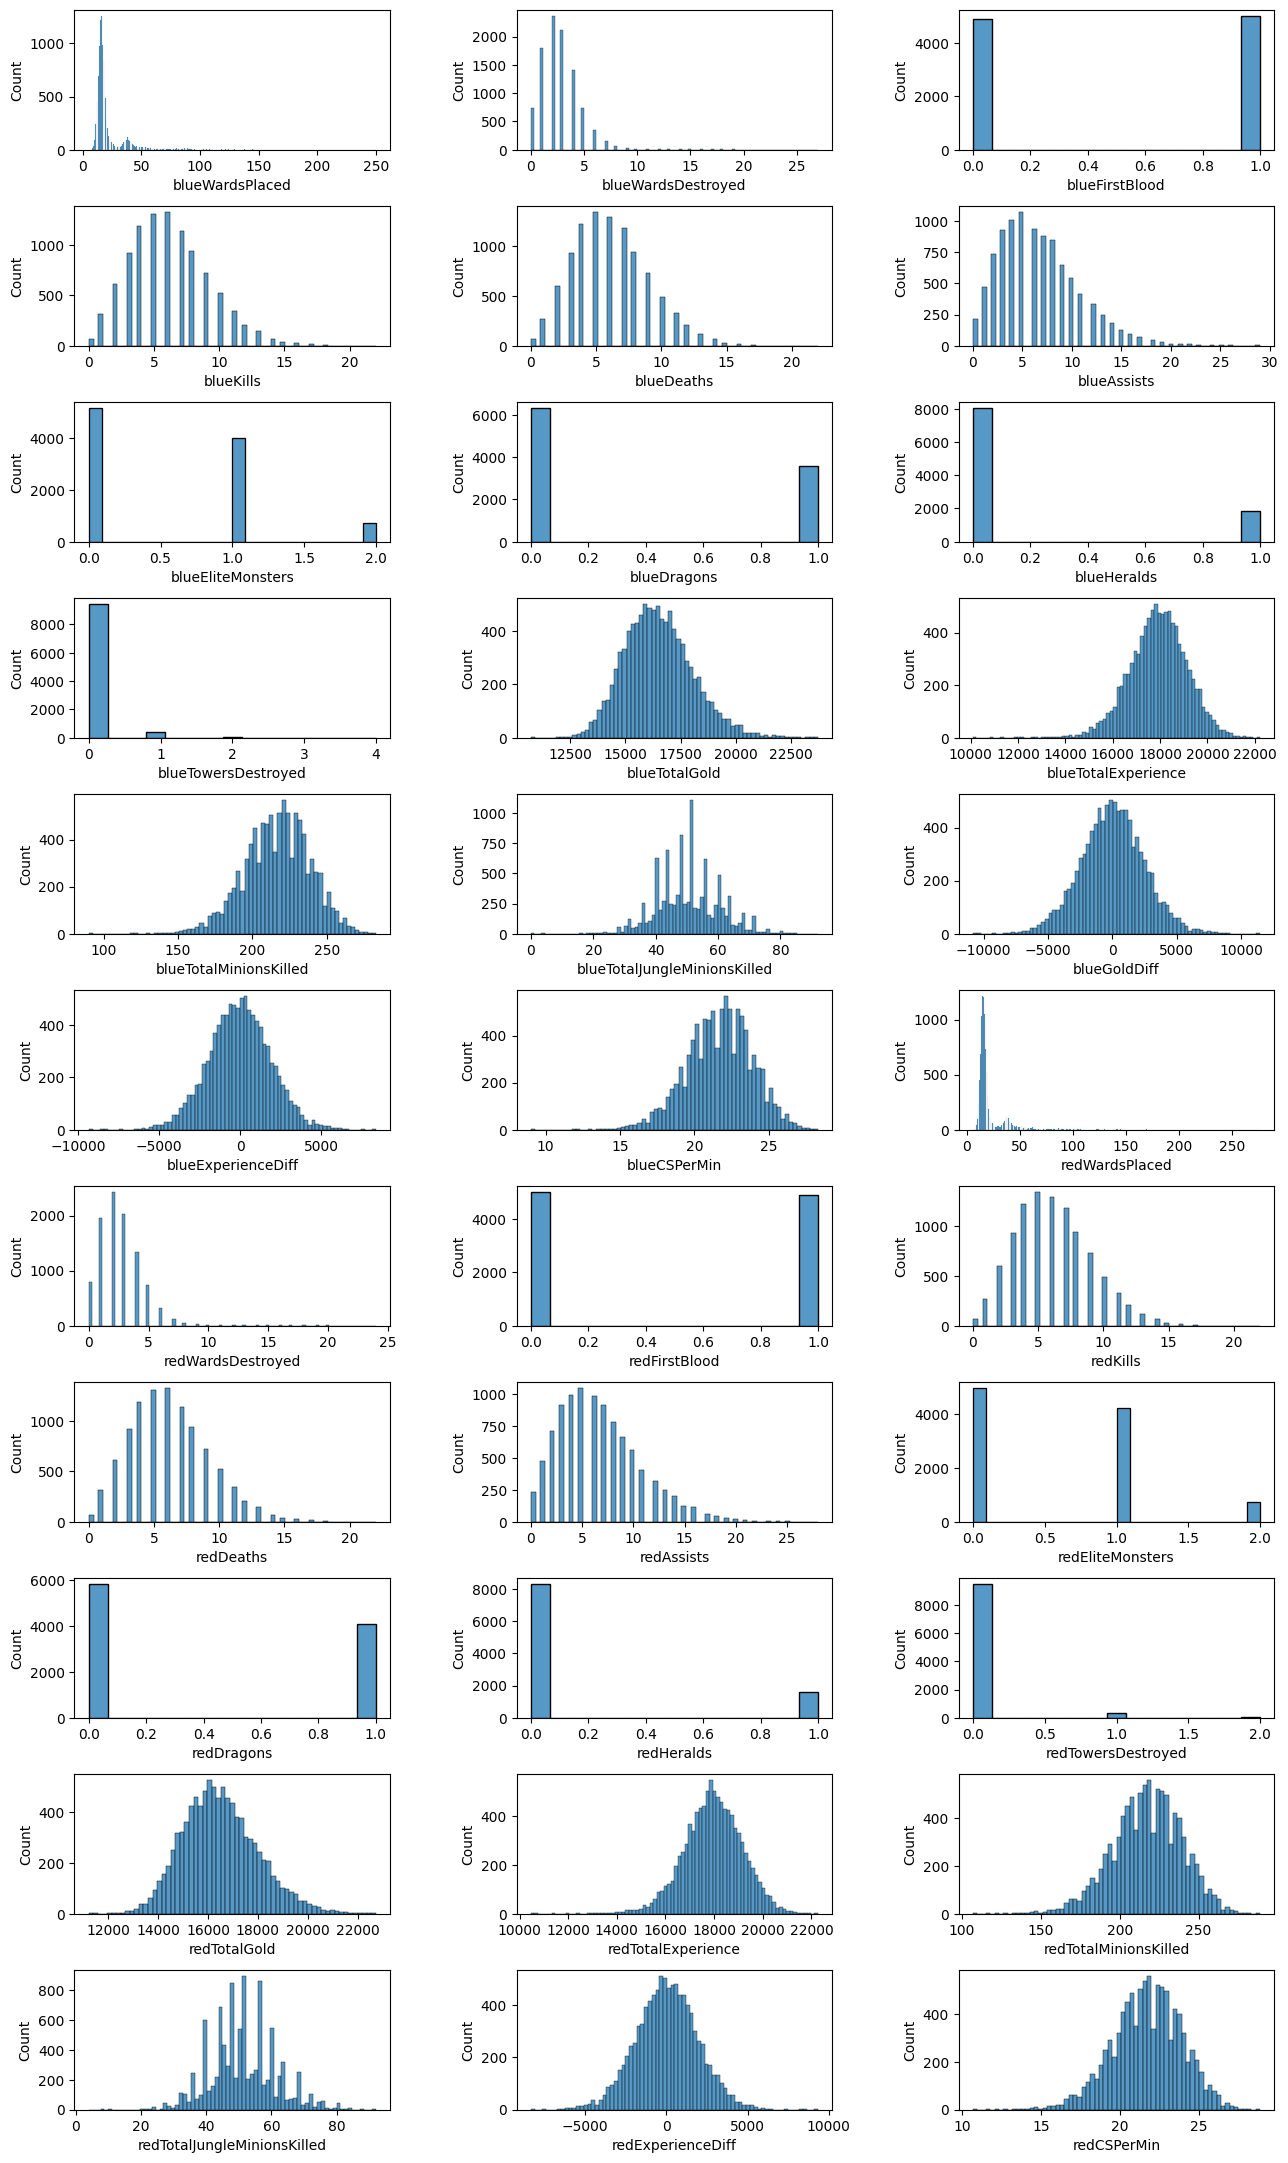

In [15]:
fig, axs = plt.subplots(11, 3, figsize=(15, 15))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1.5,
                    wspace=0.4,
                    hspace=0.4)

for index, ax in enumerate(axs.ravel()):
    sns.histplot(data=data, x=X.columns[index], ax=ax)
    ax.set_xlabel(X.columns[index])

<h4>Bivariate Analysis</h4>

blueEliteMonsters
0    5156
1    4013
2     710
Name: count, dtype: int64
blueHeralds
0    8022
1    1857
Name: count, dtype: int64
blueDragons
0    6303
1    3576
Name: count, dtype: int64
redEliteMonsters
0    4947
1    4202
2     730
Name: count, dtype: int64
redHeralds
0    8298
1    1581
Name: count, dtype: int64
redDragons
0    5798
1    4081
Name: count, dtype: int64


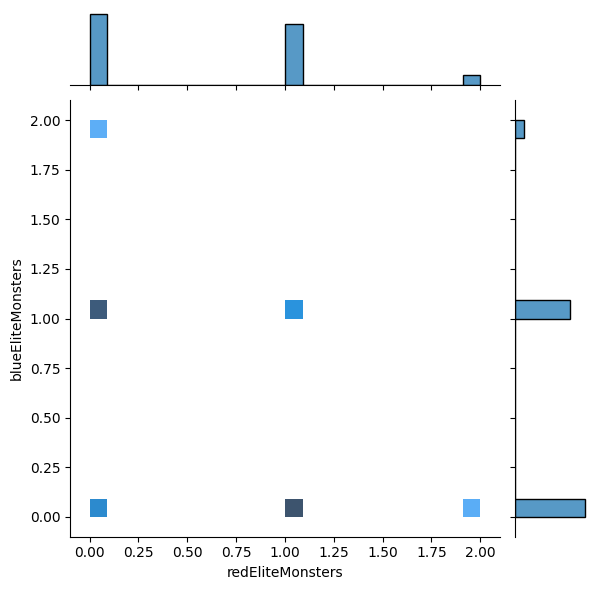

In [16]:
print(X['blueEliteMonsters'].value_counts())
print(X['blueHeralds'].value_counts())
print(X['blueDragons'].value_counts())

print(X['redEliteMonsters'].value_counts())
print(X['redHeralds'].value_counts())
print(X['redDragons'].value_counts())

sns.jointplot(data=data, kind="hist", x="redEliteMonsters", y="blueEliteMonsters")

In [17]:
blue_max_elite_loss = data.loc[(data['blueEliteMonsters'] == 2) & (data['blueWins'] == 0)]
print(f"Percent of games where blue obtained max elite monsters (2) and still lost: {100 * blue_max_elite_loss.shape[0] / data.shape[0]:.2f}%")

Percent of games where blue obtained max elite monsters (2) and still lost: 1.90%


<h4>Analysis Summary</h4>

The data analysis shows that the two target classes are we
ll balanced, so there is no need to manage the balancing through sampling methods. It also shows that the total gold for either team is usually on the low-end. Coupled with the balance of the two classes, this most likely means that total gold is an important feature for determining the outcome of the game. Also, from examining the total elite monsters of the two teams against each other, the same can be said for that feature. However, that feature itself is an addition of the blue/red dragons and herald features. Even though it doesn't add any extra information, I didn't remove it because I wasn't sure if it counted other monsters as elite monsters, and it was useful to create the jointplot visualization. From the graph, it appears it doesn't count other monsters, as the other monsters are relatively easy to take and are always taken every game.

In [18]:
X = data.loc[:, [c for c in X.columns if c != "redEliteMonsters" and c != "blueEliteMonsters"]]
print(X.columns)

Index(['blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills',
       'blueDeaths', 'blueAssists', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueTotalExperience',
       'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled',
       'blueGoldDiff', 'blueExperienceDiff', 'blueCSPerMin', 'redWardsPlaced',
       'redWardsDestroyed', 'redFirstBlood', 'redKills', 'redDeaths',
       'redAssists', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redTotalExperience', 'redTotalMinionsKilled',
       'redTotalJungleMinionsKilled', 'redExperienceDiff', 'redCSPerMin'],
      dtype='object')


<h3>Building the Model</h3>

In [19]:
# Train test split
rs = 333
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
print(f"X_train is {X_train.shape[0] * 100 / X.shape[0]:.2f}% of total data")
X_train.head()

X_train is 70.00% of total data


,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,...,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redExperienceDiff,redCSPerMin
8530,18,1,0,7,5,2,0,0,0,15533,...,9,1,1,0,15386,16849,180,44,-582,18.0
4314,39,2,1,4,4,6,1,0,0,15811,...,6,0,0,0,15650,17868,222,45,97,22.2
7418,17,2,1,7,3,8,0,0,0,16990,...,2,0,0,0,14425,16373,212,41,-1235,21.2
3277,16,5,1,3,7,5,0,0,0,15142,...,9,1,1,0,16993,19367,242,59,1813,24.2
6036,12,2,0,7,11,4,0,0,0,15528,...,12,0,0,0,19074,19125,238,65,1919,23.8


<h4>Model Selection</h4>

Here I create four models:
<ul>
    <li><b>Logistic Regression</b> with CV</li>
    <li><b>K Nearest Neighbors</b></li>
    <li><b>Simple Binary Tree</b></li>
    <li><b>Random Forest</b> with Parameters Tuned using GridSearchCV</li>
</ul>

After fitting them, I then make predictions on the test set. I use those predictions to measure the models' F1 Score and Accuracy. Using these two scores seems like the best

In [20]:
# Use a logistic regression with cross validation
steps = [
    ("scaler", StandardScaler()),
    ("logistic_regression", LogisticRegressionCV(Cs=np.logspace(start=-3, stop=4, num=10), cv=3, penalty='elasticnet', solver='saga', l1_ratios=np.linspace(start=0, stop=1, num=10), max_iter=1000))
]
pipe = Pipeline(steps=steps)
pipe.fit(X_train, y_train)
yhat = pipe.predict(X_test)
print(get_metrics(y_test, yhat))
print(f"Best C: {pipe.named_steps["logistic_regression"].C_[0]:.5f}")
print(f"Best L1 Ratio: {pipe.named_steps["logistic_regression"].l1_ratio_[0]:.3f}")

{'F1_Score': 0.7388704318936877, 'Accuracy_Score': 0.7348178137651822}
Best C: 0.00599
Best L1 Ratio: 0.556


In [21]:
# Now use KNN to predict
steps[1] = ("knn", KNeighborsClassifier(n_neighbors=3, n_jobs=-1))
pipe = Pipeline(steps=steps)
pipe.fit(X_train, y_train)
yhat = pipe.predict(X_test)
get_metrics(y_test, yhat)

{'F1_Score': 0.6731478377472342, 'Accuracy_Score': 0.6710526315789473}

In [22]:
# Now use a simple binary tree classifier
btree = DecisionTreeClassifier(criterion="entropy", random_state=rs)
btree.fit(X_train, y_train)
yhat = btree.predict(X_test)
get_metrics(y_test, yhat)

{'F1_Score': 0.6550016507098052, 'Accuracy_Score': 0.6474358974358975}

In [23]:
# Now use a random forest classifier with grid search cross validation to tune the parameters
param_grid = {
    'max_features': ["sqrt", "log2", None],
    'max_samples': [None, 0.5, 0.33, 0.25]
}

grid_search = GridSearchCV(RandomForestClassifier(n_estimators=125, criterion="entropy", n_jobs=-1, random_state=rs), param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
yhat = grid_search.predict(X_test)
print(get_metrics(y_test, yhat))

{'F1_Score': 0.7304700710179235, 'Accuracy_Score': 0.7311066126855601}


In [24]:
print(grid_search.best_params_)

{'max_features': 'sqrt', 'max_samples': 0.5}


The model that obtained the highest F1 and Accuracy scores is the <b>Logistic Regression</b> model. 
This model also fits and predicts quickly, being extremely efficient most likely because the outcomes are linearly separable. 
I will now proceed by interpreting the Logistic Regression model with the best parameters.

<h4>Model Interpretation</h4>

In [25]:
# Using the best parameters found, create the logistic regression model after scaling
steps = [
    ("scaler", StandardScaler()),
    ("logistic_regression", LogisticRegression(C=0.00599, l1_ratio=0.667, penalty='elasticnet', solver='saga', max_iter=10000, n_jobs=-1))
]
pipe = Pipeline(steps=steps)

# Fit the training data
pipe.fit(X_train, y_train)

# Predict on the test data
yhat = pipe.predict(X_test)

# Get the F1 Score and Accuracy Score
print(get_metrics(y_test, yhat))

{'F1_Score': 0.7376122381110742, 'Accuracy_Score': 0.7338056680161943}


In [26]:
# Find the important features by those that have absolute value greater than coefficient_cutoff
coefficient_cutoff = 0.1
important_features = []
for index, c in enumerate(pipe.named_steps["logistic_regression"].coef_[0]):
    if abs(c) > coefficient_cutoff:
        important_features.append(X.columns[index])

print(f"Important Feature Names:\n{important_features}")

Important Feature Names:
['blueDragons', 'blueTotalGold', 'blueGoldDiff', 'blueExperienceDiff', 'redTotalGold', 'redExperienceDiff']


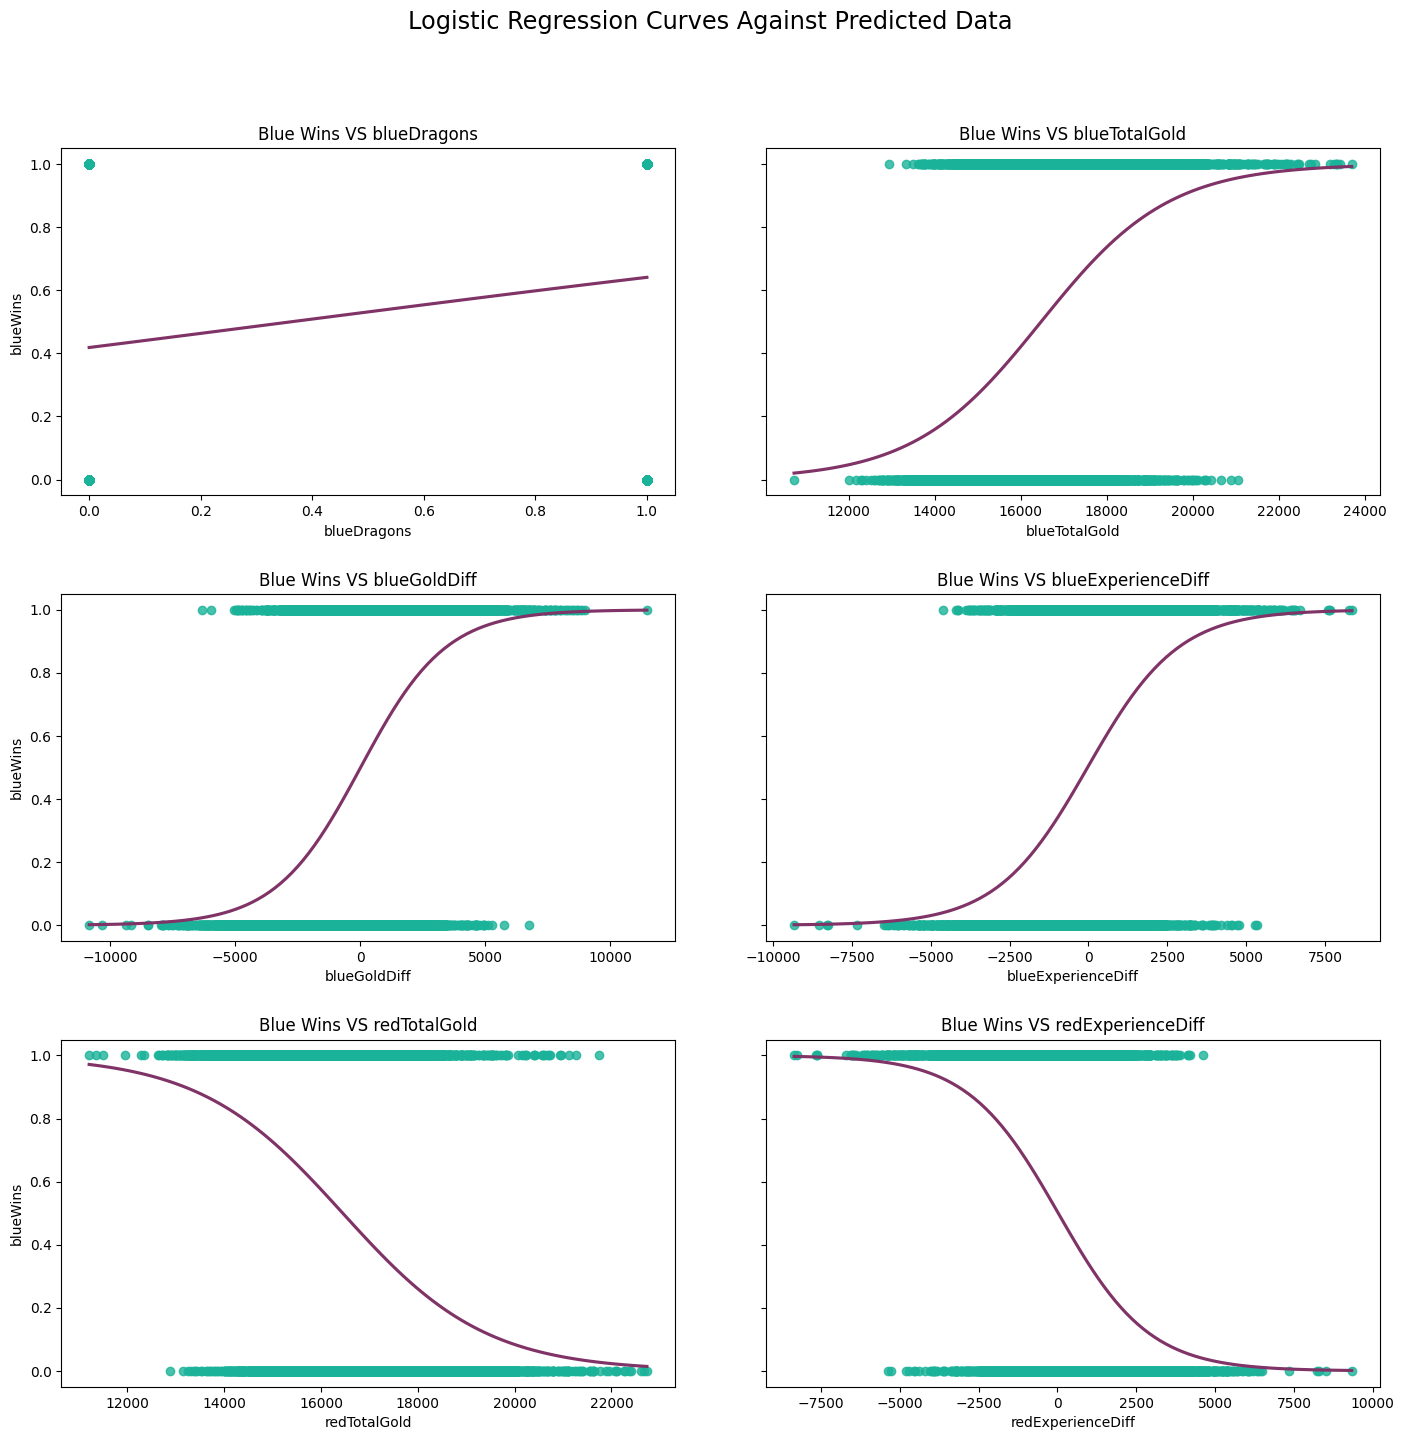

In [27]:
# Plot the logistic regression line over the predicted data scatter
fig, axs = plt.subplots(int(len(important_features) / 2), 2, figsize=(15, 15), sharey=True)
fig.suptitle("Logistic Regression Curves Against Predicted Data", fontsize="xx-large")
fig.tight_layout(pad=5.0)
for index, ax in enumerate(axs.ravel()):
    ax.set_title(f"Blue Wins VS {important_features[index]}")
    sns.regplot(data=data, x=important_features[index], y="blueWins", logistic=True, ci=None, ax=ax, color=(.1, .7, .6), line_kws=dict(color=(0.5, 0.2, 0.4)))
    if index % 2 == 1:
        ax.set_ylabel("")

<h4>Exemplifying Interpretability</h4>

I predict on the average values for all features except red and blue dragons. I instead change those to either 1 or 0 and the other being the opposite, and then predict on both those to find the difference in probabilities. This would allow a player to know how much more likely it would be to win the game if they take dragon instead of the opposing team. As I show, it increases the blue teams odds by almost 24% if they take the first dragon instead of the red team taking it. This is an example of how a player could use this model's interpetability to increase their win/loss ratio

In [28]:
# Create dummy dataframe with one entry that has the mean value for every feature
entry = {}
for column in X_test:
    entry[column] = [X_test.loc[:, column].mean()]
interp_test = pd.DataFrame(entry)
interp_test.head()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,...,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redExperienceDiff,redCSPerMin
0,22.184885,2.876181,0.520243,6.217274,6.11471,6.680499,0.367746,0.182186,0.051282,16523.604251,...,6.654184,0.40722,0.152834,0.038799,16464.816464,17960.196356,217.138664,51.269231,13.088057,21.713866


In [29]:
# Make the blue team have zero dragons, and the red team have one
interp_test["blueDragons"] = 0
interp_test["redDragons"] = 1

# Display the difference in prediction probabilities between the positive class outcome and the negative class outcome
interp_predict = pipe.predict(interp_test)
print("Red team takes first dragon")
print(f"{"Blue winning" if interp_predict[0] == 1 else "Red winning"} is{(pipe.predict_proba(interp_test)[:,interp_predict[0]][0] * 2 - 1) * 100: .2f}% more likely than {"blue winning" if interp_predict[0] == 0 else "red winning"}")

Red team takes first dragon
Red winning is 12.72% more likely than blue winning


In [30]:
# Now make the blue team have one dragon and the red team have none
interp_test_blueD = interp_test.copy()
interp_test_blueD["blueDragons"] = 1
interp_test_blueD["redDragons"] = 0

# Display the difference in prediction probabilities between the positive class outcome and the negative class outcome
interp_predict_blueD = pipe.predict(interp_test_blueD)
print("Blue team takes first dragon")
print(f"{"Blue winning" if interp_predict_blueD[0] == 1 else "Red winning"} is{(pipe.predict_proba(interp_test_blueD)[:,interp_predict_blueD[0]][0] * 2 - 1) * 100: .2f}% more likely than {"blue winning" if interp_predict_blueD[0] == 0 else "red winning"}")

Blue team takes first dragon
Blue winning is 10.94% more likely than red winning


<h4>Model Building Summary</h4>

Ultimately, the model that won out in both interpretability and F1 Score as well as Accuracy was a simple logistic regression model with elastic net regularization with C as 0.00599, and an L1 Ratio of 0.667. The final F1 Score obtained was 0.738 and the Accuracy Score was 0.734. I did not pursue tuning other models to increase the score because the interpretability of the regular logistic regression model is superior. I showed that the most influential features are Blue Dragons, Blue Total Gold, Blue Gold Diff, Blue Experience Difference, Red Total Gold, and Red Experience Difference. Using that knowledge, I created an example of using the interpretability of the model by showing how a player could use it to increase their prediction probability, in turn most likely increasing their win/loss ratio over time.

<h3>Conclusion</h3>

The overall goal was met with a balance of interpretability and F1 and Accuracy scores. The model lacks the accuracy that I would like however, and therefore this problem could be revisited later with a different dataset. Keeping the logistic regression model to predict and only increasing the complexity of the dataset is the best course of action without compromising the original plan of prioritizing interpretability. Features I would like to see in a new dataset would be amount of players using champions with high mastery scores (how much the players have played as those particular playable characters), and maybe somehow a measure of champion countering (using playable characters that have a high win/loss ratio against the opposing playable characters). With these features, the model is likely to perform better because of how champion interactions work within the game. Also, since players are not always placed in games where the skill levels of both teams are balanced, a measure of overall team skill level would most likely be an important feature as well. Ultimately, the logistic regression model created can fairly accurately predict the winner of high elo League of Legends game at the 10 minute mark and do it with a high level of interpretability. These two attributes could allow this model to be used within a web application that helps players increase their win/loss ratio.